In [1]:
import math
import numpy as np
import pandas as pd

from sklearn import linear_model 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from dataclasses import dataclass

In [2]:
dataset_material = pd.read_excel('Data_Ghiringhelli.xlsx', 'Material Data')
dataset_atomic = pd.read_excel('Data_Ghiringhelli.xlsx',   'Atomic Data')
dataset_atomic.columns = ['Z', 'A', 'IP', 'EA', 'HOMO', 'LUMO', 'rs', 'rp', 'rd', '1D']

In [3]:
def get_row(element,dataframe):
    return (dataframe.loc[dataframe['A']==element])

def collecting_descriptor(a,b, dataframe=dataset_atomic):
    row_a = get_row(element=a, dataframe=dataframe)
    row_b = get_row(element=b, dataframe=dataframe)
    return row_a,row_b

def get_feature(dataframe=dataset_material):
    feature_array = []
    for kk in range(len(dataframe.values)):
        el_a,el_b   = (dataframe.values)[kk][2:4]
        row_a,row_b = collecting_descriptor(a=el_a, b=el_b)
        res = formula(row_a, row_b)
        feature_array.append(res[0])
    return np.array(feature_array).reshape(-1,1)

In [4]:
# Luca descriptor
def formula(a,b):
    return ((b['EA'].values-b['IP'].values)/(a['rp'].values**2))

In [5]:
X = get_feature()
y = dataset_material['DE'].values

### Checking with linear model

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_regressior = LinearRegression()
mse = cross_val_score(lin_regressior, X, dataset_material['DE'].values, scoring='neg_mean_squared_error',cv=8)

In [7]:
abs(np.mean(mse))

0.021040010378385838

### checking with Ridge regressor

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=8)
ridge_regressor.fit(X,dataset_material['DE'].values)

GridSearchCV(cv=8, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [9]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 1}
-0.02103844380947445


In [10]:
mse = []
for ii in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, dataset_material['DE'].values, test_size=0.1, random_state=ii)
    regressor = LinearRegression()
    regressor.fit((np.array(X_train)).reshape(-1,1), y_train)
    y_pred = regressor.predict((np.array(X_test)).reshape(-1,1))
    mse.append(mean_squared_error(y_test,y_pred))
avg = float(np.average(mse))
print('avg rmse = ',avg)

avg rmse =  0.021409625262275345


In [11]:
grid_array = []
alpha_lst  = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for ii in range(1000):
    temp = []
    X_train, X_test, y_train, y_test = train_test_split(X, dataset_material['DE'].values, test_size=0.1, random_state=ii)
    for jj in alpha_lst:
        regressor = Ridge(alpha=jj)
        regressor.fit((np.array(X_train)).reshape(-1,1), y_train)
        y_pred = regressor.predict((np.array(X_test)).reshape(-1,1))
        temp.append(mean_squared_error(y_test,y_pred))
    grid_array.append(temp)
grid_array = np.array(grid_array)

In [12]:
alpha_dict = dict()
for i in range(len(grid_array[0])):
    alpha_dict[str(alpha_lst[i])] = []
    alpha_dict[str(alpha_lst[i])].append(np.average(grid_array[:,i]))

In [13]:
alpha_dict

{'0.0001': [0.021190747706989463],
 '0.001': [0.021190753454091528],
 '0.01': [0.02119081096252875],
 '0.1': [0.021191389787222462],
 '1': [0.021197550734853975],
 '10': [0.021295136229432444],
 '100': [0.02486780167633814],
 '1000': [0.08625952509223439]}

### Cheking with Lasso

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=8)
lasso_regressor.fit(X,dataset_material['DE'].values)

GridSearchCV(cv=8, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [15]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.001}
-0.021039205538824796


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=0)

In [17]:
ridge_prediction = ridge_regressor.predict(X_test)
lasso_prediction = lasso_regressor.predict(X_test)

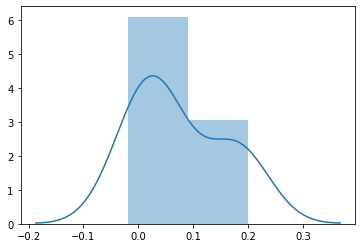

In [18]:
import seaborn as sns
sns.distplot(y_test-lasso_prediction)

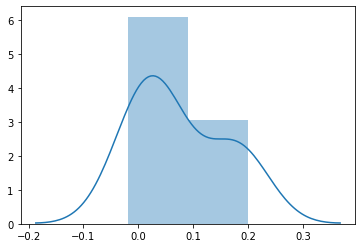

In [19]:
import seaborn as sns
sns.distplot(y_test-ridge_prediction)

### KRR

In [20]:
from sklearn.kernel_ridge import KernelRidge
regressor = KernelRidge(alpha = 0.001, kernel='rbf', gamma = 0.001)

In [21]:
regressor.fit(X_train,y_train)

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001, kernel='rbf',
            kernel_params=None)

In [22]:
regressor.predict(X_test)

array([-0.15259916, -0.08467925, -0.0670093 ,  0.1681122 ,  1.60650098,
        0.41457156,  0.05332626, -0.17536728,  0.23412942])

In [23]:
mean_squared_error(y_test,regressor.predict(X_test))

0.013532070973557662

In [24]:
grid_array = []
alpha_lst  = [3.0e-4]
gamma_list = [1.0 / 3000]
for jj in alpha_lst:
    temp2 = []
    for kk in gamma_list:
        temp = []
        for ii in range(1000):
            X_train, X_test, y_train, y_test = train_test_split(X, dataset_material['DE'].values, test_size=0.1, random_state=ii)
            regressor = KernelRidge(alpha = jj, kernel='rbf', gamma = kk)
            regressor.fit((np.array(X_train)).reshape(-1,1), y_train)
            y_pred = regressor.predict((np.array(X_test)).reshape(-1,1))
            temp.append(mean_squared_error(y_test,y_pred))
        temp2.append(temp)
    grid_array.append(temp2)
grid_array = np.array(grid_array)

In [25]:
save_min = []
for ii in range(len(grid_array)):
    for jj in range(len(grid_array[ii])):
        save_min.append(np.average(grid_array[ii][jj]))

In [26]:
save_min

[0.023131288459565105]